### Whole-brain model 

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding")

In [2]:
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from fooof import FOOOF
from fooof.plts.spectra import plot_spectra
from fooof.sim.gen import gen_aperiodic
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency import psd_array_multitaper
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/tmp/ipykernel_781940/3585325369.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [3]:
jax.config.update("jax_platform_name", "cpu")

######################################################################################
#### FUNCTIONS
######################################################################################

In [4]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    return roi_s, roi_t

In [5]:
def xr_psd_array_multitaper(data, bandwidth=1.0, n_jobs=1, fmin=0.1, fmax=80):
    _, roi, _ = data.trials.values, data.roi.values, data.time.values

    psds_c, freqs, _ = psd_array_multitaper(
        data,
        data.fsample,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
    )

    # Spectra
    sxx = (psds_c * np.conj(psds_c)).mean((0, 2)).real

    sxx = xr.DataArray(sxx, dims=("roi", "freqs"), coords=(roi, freqs))

    return sxx

In [6]:
from scipy.special import gamma


def alpha_function(t, alpha, tau_decay):
    """
    Generates an alpha function as the envelope.
    """
    return (
        (alpha) * np.exp(-t / tau_decay) / (tau_decay * (alpha + 1) * gamma(alpha + 1))
    )


def evoked_potential(t, A, f_initial, f_final, t_transition, alpha, tau_decay):
    # Initialize the signal
    signal = np.zeros_like(t)

    # Time after the transition point (where the stimulus starts)
    stimulus_start_idx = t >= t_transition
    t_stimulus = t[stimulus_start_idx] - t_transition  # Time after stimulus start

    # Frequency decay over time
    freq_t = f_initial + (f_final - f_initial) * t_stimulus / t_max

    # Oscillatory signal with frequency decay
    oscillatory_signal = A * np.cos(2 * np.pi * freq_t * t_stimulus)

    # Apply the alpha envelope to the oscillatory signal
    envelope = alpha_function(t_stimulus, alpha, tau_decay)

    # Combine the oscillatory signal with the decaying envelope
    signal[stimulus_start_idx] = oscillatory_signal * envelope

    return signal

######################################################################################
#### LOAD EMPIRICAL POWER SPECTRA
######################################################################################

In [7]:
areas_data = np.array(
    [
        "AIP",
        "Caudate",
        "Claustrum",
        "Core",
        "DP",
        "F1",
        "F2",
        "F6",
        "F7",
        "FST",
        "Ins",
        "LIP",
        "MB",
        "MIP",
        "MST",
        "MT",
        "OPRO",
        "PBr",
        "PIP",
        "Putamen",
        "SII",
        "STPc",
        "TPt",
        "Thal",
        "V1",
        "V2",
        "V3",
        "V3A",
        "V4",
        "V4t",
        "V6A",
        "VIP",
        "a1",
        "a11",
        "a12",
        "a13",
        "a14",
        "a2",
        "a23",
        "a24D",
        "a24c",
        "a3",
        "a32",
        "a44",
        "a45A",
        "a45B",
        "a46D",
        "a46V",
        "a5",
        "a7A",
        "a7B",
        "a7M",
        "a7op",
        "a8B",
        "a8L",
        "a8M",
        "a8r",
        "a9/46D",
        "a9/46V",
    ],
    dtype=object,
)


area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "a8M",
    "a5",
    "a8L",
    "TEO",  ##
    "a2",
    "F1",
    "STPc",
    "a7A",
    "a46D",
    "10",  ##
    "a9/46V",
    "a9/46D",
    "F5",  ##
    "TEpd",  ##
    "PBr",
    "a7M",
    "a7B",
    "F2",
    "STPi",  ##
    "PROm",  ##
    "F7",
    "a8B",
    "STPr",  ##
    "a24c",
]

In [8]:
session_numbers = os.listdir("/home/INT/lima.v/Results/phase_encoding/psd/lucy")

In [9]:
sxx, peak_freqs, peak_power = [], [], []

for session in tqdm(session_numbers):

    sxx_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/sxx.nc"
    )
    peak_freqs_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_freqs.nc"
    )
    peak_power_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_power.nc"
    )

    _, roi_data = _extract_roi(peak_freqs_.roi.values, "_")
    sxx_ = sxx_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    peak_freqs_ = (
        peak_freqs_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )
    peak_power_ = (
        peak_power_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )

    sxx += [sxx_]
    peak_freqs += [peak_freqs_]
    peak_power += [peak_power_]

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 80.35it/s]


In [10]:
peak_freqs = xr.concat(peak_freqs, "sessions").mean("sessions")[0]
peak_power = xr.concat(peak_power, "sessions").mean("sessions")[0]

In [11]:
# Data power spectrum
sxx_data = xr.concat(sxx, "sessions").mean("sessions").groupby("roi").mean("roi")[0]
# sxx_data = sxx_data / sxx_data.max("freqs")

In [12]:
unique_rois = sxx_data.roi.values

sca = ["Caudate", "Claustrum", "Thal", "Putamen"]

idx = np.logical_not([s in sca for s in unique_rois])

unique_rois[idx]

array(['AIP', 'Core', 'DP', 'F1', 'F2', 'F6', 'F7', 'FST', 'Ins', 'LIP',
       'MB', 'MIP', 'MST', 'MT', 'OPRO', 'PBr', 'PIP', 'SII', 'STPc',
       'TPt', 'V1', 'V2', 'V3', 'V3A', 'V4', 'V4t', 'V6A', 'VIP', 'a1',
       'a11', 'a12', 'a13', 'a14', 'a2', 'a23', 'a24D', 'a24c', 'a3',
       'a32', 'a44', 'a45A', 'a45B', 'a46D', 'a46V', 'a5', 'a7A', 'a7B',
       'a7M', 'a7op', 'a8B', 'a8L', 'a8M', 'a8r', 'a9/46D', 'a9/46V'],
      dtype=object)

######################################################################################
#### FLATTEN DATA PSD
######################################################################################

In [13]:
freqs = sxx_data.freqs.data

sxx_data_flat = []

for roi in unique_rois:

    fm = FOOOF(verbose=False)

    spectrum = sxx_data.sel(roi=roi).values

    fm.add_data(freqs, spectrum, [1, 80])
    fm.fit(freqs, spectrum, [1, 80])

    init_ap_fit = gen_aperiodic(
        fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum)
    )

    sxx_data_flat += [fm.power_spectrum - init_ap_fit]

sxx_data.values = np.stack(sxx_data_flat)

######################################################################################
#### FIT MODEL TO DATA
######################################################################################

In [14]:
# Swap parameters


if not (
    os.path.isfile("data/f_model.nc")
    and os.path.isfile("data/a_model.nc")
    and os.path.isfile("data/beta_model.nc")
):

    simulate_vmap = jax.vmap(
        simulate,
        in_axes=(None, None, 0, 0, None, 0, None, None, None, None, None, None),
    )

    beta_vec = np.linspace(1e-5, 1e-2, 30)
    f_vec = np.linspace(0.1, 80, 30)
    a_vec = np.linspace(-15, -2, 30)

    params = np.array(np.meshgrid(a_vec, f_vec, beta_vec)).T.reshape(-1, 3)

    n_trials = 50
    dt = 1e-4
    fsamp = 1 / dt
    time = np.arange(0, 0.4, 1 / fsamp)
    beta = 1e-4
    Npoints = len(time)
    decim = 10

    out = []

    for i in tqdm(range(n_trials)):

        out += [
            simulate_vmap(
                np.zeros(1),
                0,
                params[:, 1],
                params[:, 0],
                fsamp,
                params[:, 2],
                Npoints,
                None,
                0,
                "cpu",
                decim,
                "both",
            )
        ]

    data = xr.DataArray(
        np.stack(out).real,
        dims=("trials", "roi", "time"),
        coords=(range(50), range(len(params)), time[::decim]),
        attrs={"fsample": 1000},
    )

    sxx_sim = xr_psd_array_multitaper(data, bandwidth=5, n_jobs=5)
    sxx_sim = sxx_sim / sxx_sim.max("freqs")

    optm = []

    for roi in tqdm(unique_rois):

        mse = [
            mean_squared_error(sxx_data.sel(roi=roi), sxx_sim_) for sxx_sim_ in sxx_sim
        ]
        optm += [params[np.argmin(mse), :]]

    a_values, peak_freqs, beta_values = np.stack(optm).T

    peak_freqs = xr.DataArray(peak_freqs, dims=("roi"), coords=(unique_rois,))
    a_values = xr.DataArray(a_values, dims=("roi"), coords=(unique_rois,))
    beta_values = xr.DataArray(beta_values, dims=("roi"), coords=(unique_rois,))

    f_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            f_model += [peak_freqs.sel(roi=area)]
        else:
            f_model += [-1]

    f_model = xr.DataArray(f_model, dims=("roi"), coords=(area_names,))

    f_model.values[8] = f_model.values[7]
    f_model.values[14] = f_model.values[13]
    f_model.values[17] = f_model.values[16]
    f_model.values[18] = f_model.values[17]
    f_model.values[23] = f_model.values[22]
    f_model.values[24] = f_model.values[23]
    f_model.values[27] = f_model.values[26]
    f_model = f_model.fillna(f_model.min())

    a_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            a_model += [a_values.sel(roi=area)]
        else:
            a_model += [-1]

    a_model = xr.DataArray(a_model, dims=("roi"), coords=(area_names,))

    a_model.values[8] = a_model.values[7]
    a_model.values[14] = a_model.values[13]
    a_model.values[17] = a_model.values[16]
    a_model.values[18] = a_model.values[17]
    a_model.values[23] = a_model.values[22]
    a_model.values[24] = a_model.values[23]
    a_model.values[27] = a_model.values[26]

    beta_model = []

    for area in area_names:
        if area in beta_values.roi.values:
            beta_model += [beta_values.sel(roi=area)]
        else:
            beta_model += [-1]

    beta_model = xr.DataArray(beta_model, dims=("roi"), coords=(area_names,))

    beta_model.values[8] = beta_model.values[7]
    beta_model.values[14] = beta_model.values[13]
    beta_model.values[17] = beta_model.values[16]
    beta_model.values[18] = beta_model.values[17]
    beta_model.values[23] = beta_model.values[22]
    beta_model.values[24] = beta_model.values[23]
    beta_model.values[27] = beta_model.values[26]

    f_model.to_netcdf("data/f_model.nc")
    a_model.to_netcdf("data/a_model.nc")
    beta_model.to_netcdf("data/beta_model.nc")

else:

    f_model = xr.load_dataarray("data/f_model.nc")
    a_model = xr.load_dataarray("data/a_model.nc")
    beta_model = xr.load_dataarray("data/beta_model.nc")

#### Load anatomical data

In [15]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

#### Simulation parameters

In [16]:
ntrials = 100
dt = 1e-4
fsamp = 1 / dt
time = np.arange(-5, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 10
f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

seeds = np.random.randint(0, 10000, ntrials)

In [17]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.4)] = 0.5
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [18]:
t_max = time.max()  # Maximum time (in seconds)
dt = 1 / fsamp  # Time step (in seconds)

A = 0.5  # Initial amplitude of the stimulus
f_initial = 60  # Initial frequency of the oscillation (60 Hz)
f_final = 10  # Final frequency after decay (e.g., 10 Hz)
t_transition = 0  # Time at which the stimulus starts (1s after baseline)
alpha = 0.5  # Shape parameter of the alpha function
tau_decay = 0.5  # Time constant for the alpha function

I_t = evoked_potential(time, A, f_initial, f_final, t_transition, alpha, tau_decay)

Iext = np.zeros((Nareas, Npoints))
Iext[0, :] = I_t
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [19]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            flnMat,
            # D,
            10,
            f,
            -5,
            fsamp,
            1e-4,
            Npoints,
            CS[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


#### Convert to xarray

In [20]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), area_names, time[::decim]),
).sel(times=slice(-2, 4))

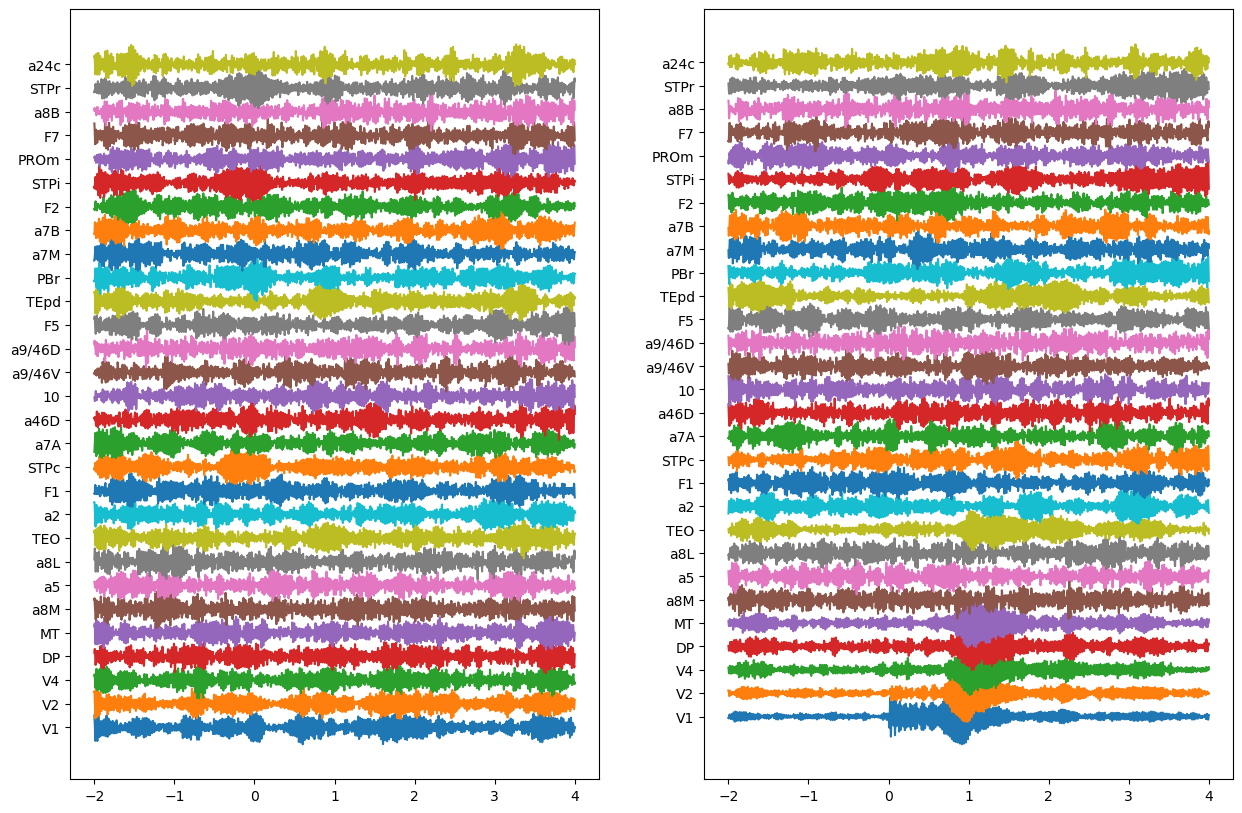

In [21]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.yticks(np.arange(0, Nareas) * 3, area_names)
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))
plt.yticks(np.arange(0, Nareas) * 3, area_names);

In [22]:
Sxx, fc = psd_array_multitaper(data.real, fsamp // decim, 0, 80, bandwidth=1)

    Using multitaper spectrum estimation with 5 DPSS windows


In [23]:
Sxx = xr.DataArray(
    Sxx,
    dims=("trials", "roi", "freqs"),
    coords={"trials": data.trials.values, "roi": data.roi.values, "freqs": fc},
)

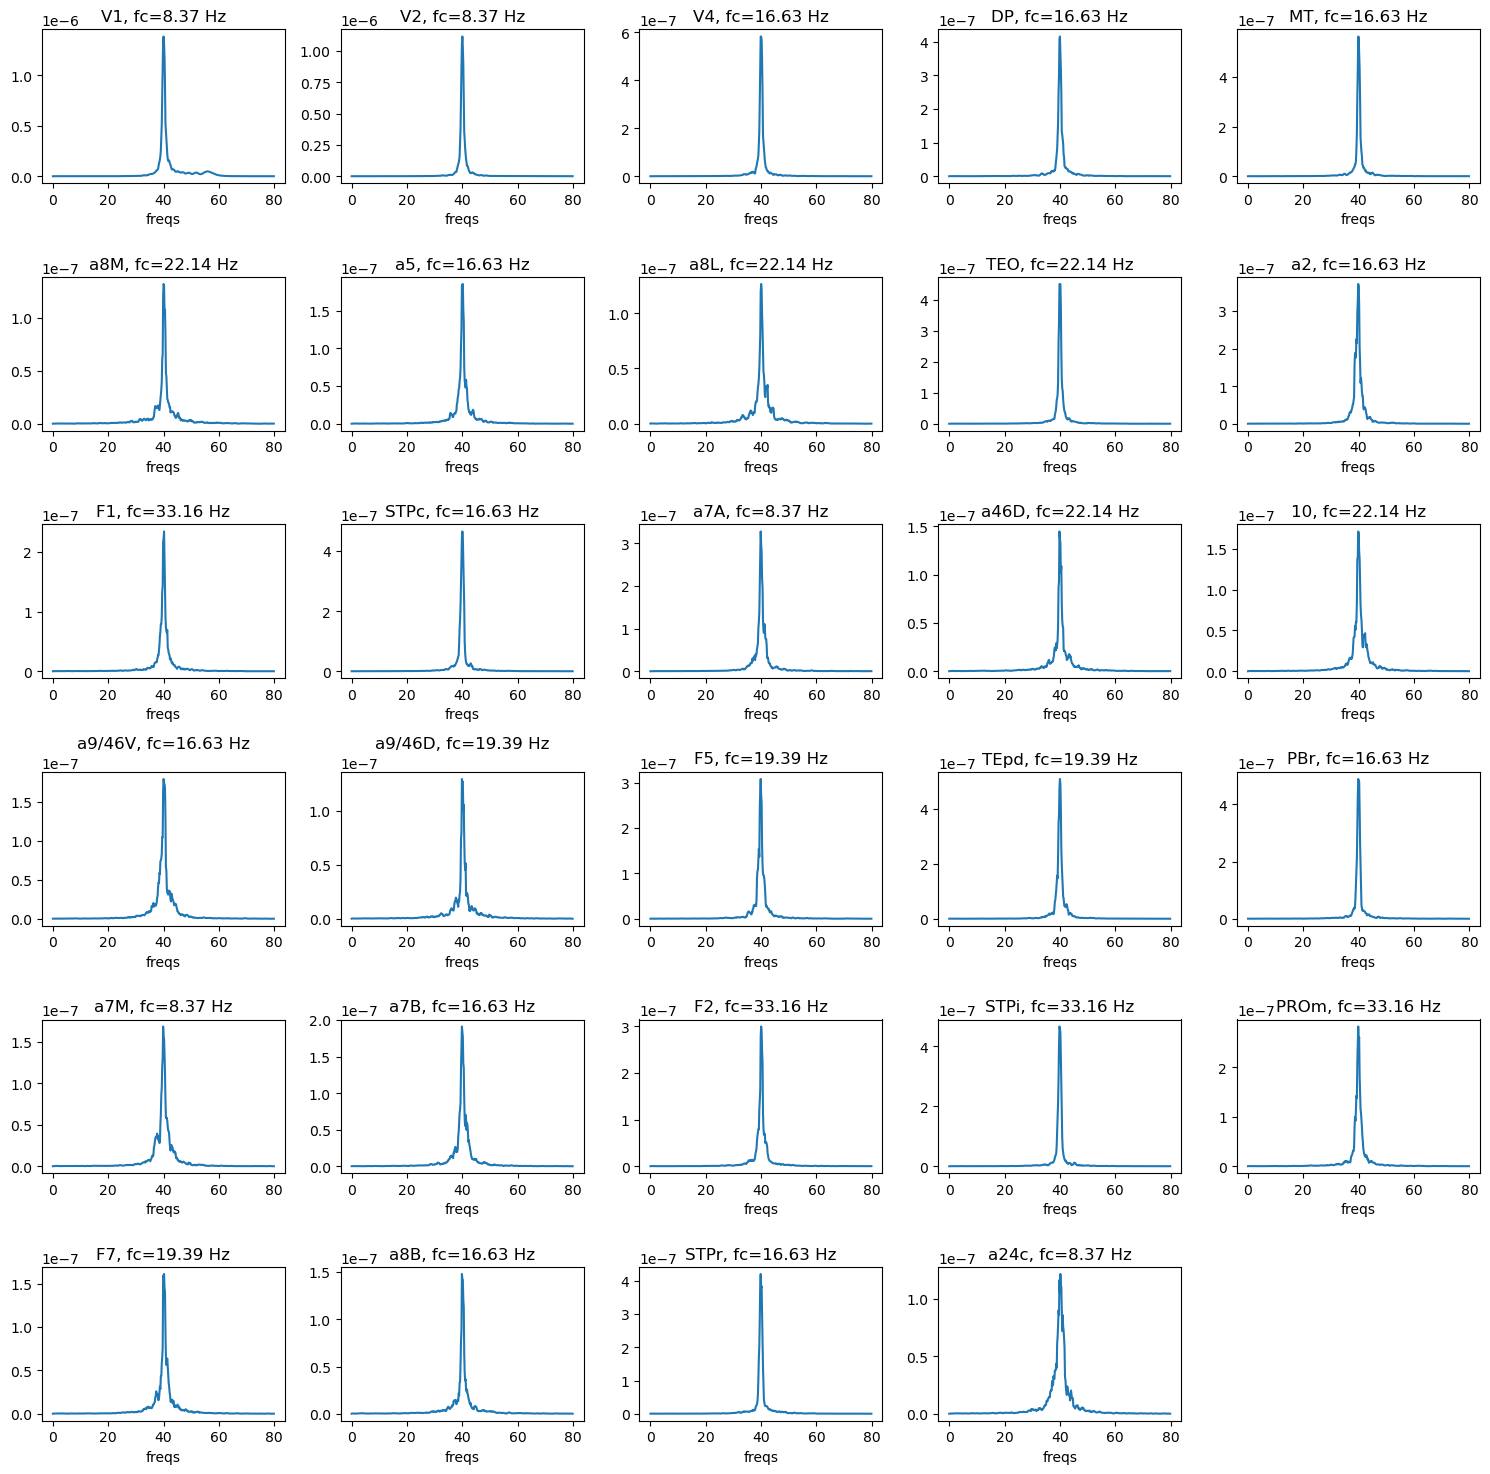

In [24]:
plt.figure(figsize=(15, 15))
for pos, i in enumerate(range(Nareas)):
    ax = plt.subplot(6, 5, pos + 1)
    Sxx.isel(roi=i).mean("trials").plot()
    plt.title(f"{area_names[i]}, fc={f_model.values[i]:.2f} Hz")
plt.tight_layout()

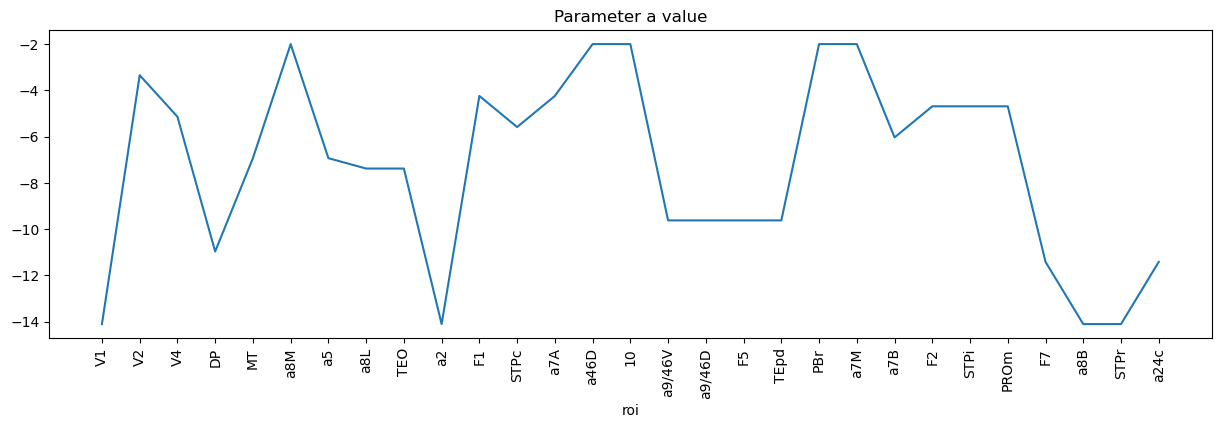

In [25]:
plt.figure(figsize=(15, 4))
a_model.plot()
plt.title("Parameter a value", fontsize=12)
plt.xticks(rotation=90);

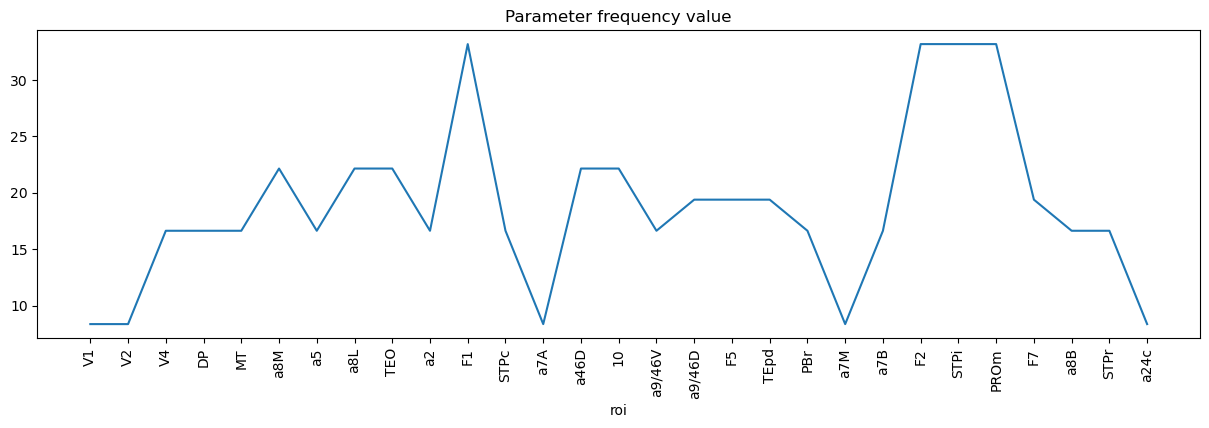

In [26]:
plt.figure(figsize=(15, 4))
f_model.plot()
plt.title("Parameter frequency value", fontsize=12)
plt.xticks(rotation=90);

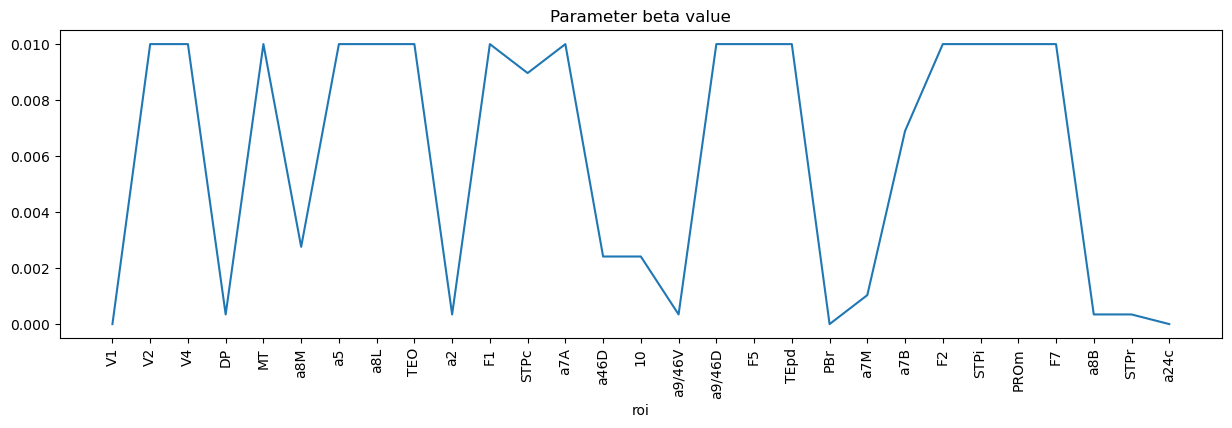

In [27]:
plt.figure(figsize=(15, 4))
beta_model.plot()
plt.title("Parameter beta value", fontsize=12)
plt.xticks(rotation=90);

In [28]:
z = data.sel(roi="V1") * np.conj(data.sel(roi="a24c"))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [29]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

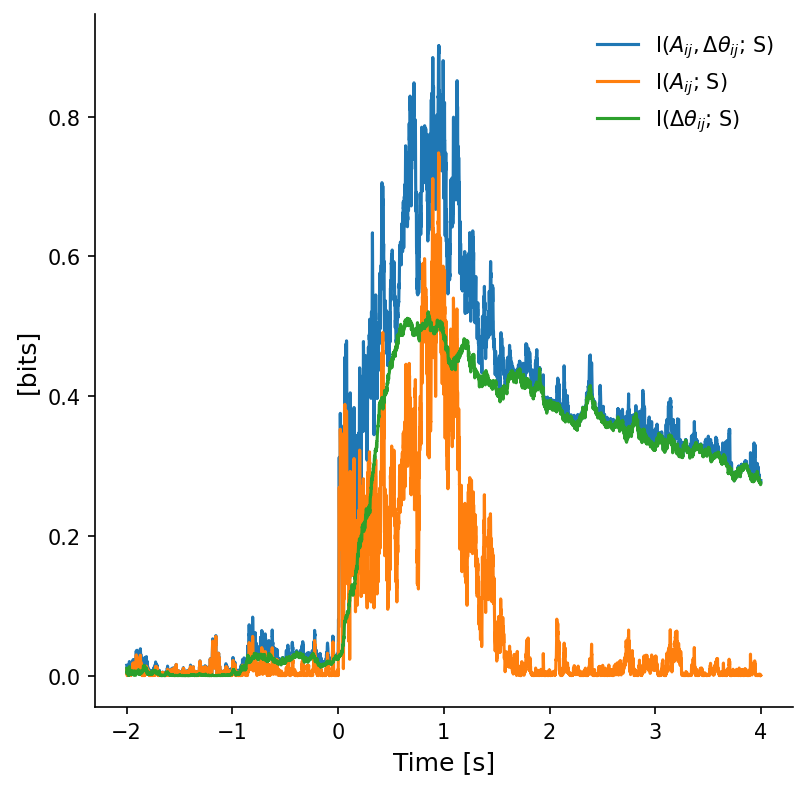

In [30]:
plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))


mv = np.stack((A, dphi), axis=0)


plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(A[None], labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(dphi[None], labels[None], False, True))

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.savefig("figures/v1_24c_encoding.png", bbox_inches="tight")

In [31]:
### Decompose in time-frequency domain
data.attrs["fsample"] = fsamp / decim
freqs = np.linspace(10, 80, 30)

S = tfr_array_multitaper(
    data.sel(roi=["V1", "a24c"]),
    data.fsample,
    freqs,
    n_cycles=25,
    time_bandwidth=5,
    output="complex",
    n_jobs=1,
    decim=2,
    zero_mean=False,
).mean(2)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values[::2]},
)

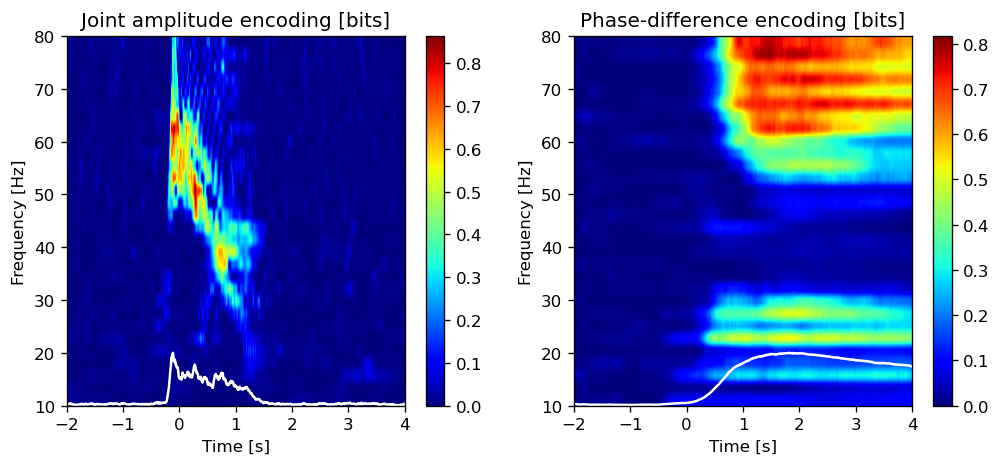

In [32]:
z = S[:, 0] * np.conj(S[:, 1])

A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

labels = np.tile(
    np.expand_dims(Amplitudes, (1, 2)), (S.sizes["freqs"], S.sizes["times"])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

plt.figure(figsize=(10, 4), dpi=120)
plt.subplot(121)
MI_A = mi_fcn_time_frequency(A[None], labels[None], False, True)
plt.imshow(
    MI_A,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Joint amplitude encoding [bits]")
plt.plot(S.times, MI_A.sum(0) / MI_A.sum(0).max() * 10 + 10, c="w")
plt.colorbar()

plt.subplot(122)
MI_PHI = mi_fcn_time_frequency(dphi[None], labels[None], False, True)
plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Phase-difference encoding [bits]")
plt.plot(S.times, MI_PHI.sum(0) / MI_PHI.sum(0).max() * 10 + 10, c="w")

plt.colorbar()

plt.savefig("figures/v1_24c_tf_encoding.png", bbox_inches="tight")

In [33]:
### Decompose in time-frequency domain
data.attrs["fsample"] = fsamp / decim
freqs = np.linspace(10, 80, 30)

S = tfr_array_multitaper(
    data.sel(roi=["V1", "a8B", "a24c"]),
    data.fsample,
    freqs,
    n_cycles=25,
    time_bandwidth=5,
    output="complex",
    n_jobs=1,
    decim=2,
    zero_mean=False,
).mean(2)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values[::2]},
)

In [53]:
e12 = np.unwrap(np.abs(S[:, 0] * np.conj(S[:, 1])))
e13 = np.unwrap(np.abs(S[:, 0] * np.conj(S[:, 2])))
e23 = np.unwrap(np.abs(S[:, 1] * np.conj(S[:, 2])))


labels = np.tile(
    np.expand_dims(Amplitudes, (1, 2)), (S.sizes["freqs"], S.sizes["times"])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

MI_12 = mi_fcn_time_frequency(e12[None], labels[None], False, True)
MI_13 = mi_fcn_time_frequency(e13[None], labels[None], False, True)

MI_123 = mi_fcn_time_frequency(np.stack((e12, e13)), labels[None], False, True)

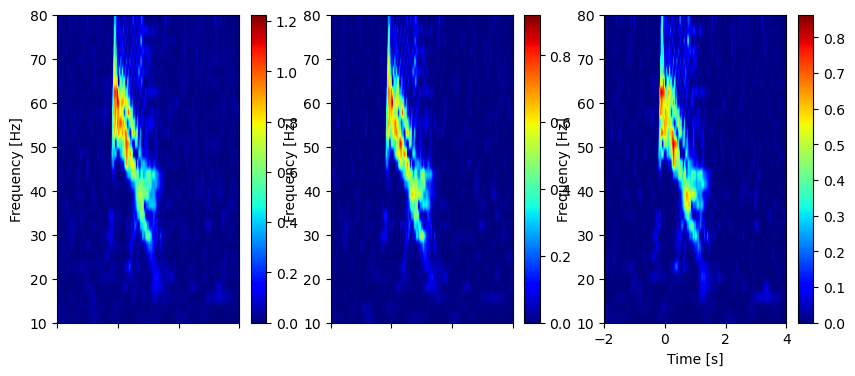

In [55]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(131)

plt.imshow(
    MI_123,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
    vmin=0,
)
plt.xticks(color="w")
plt.ylabel("Frequency [Hz]")
plt.colorbar()

ax = plt.subplot(132)
plt.imshow(
    MI_12,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
    vmin=0,
)
plt.xticks(color="w")
plt.ylabel("Frequency [Hz]")
plt.colorbar()


ax = plt.subplot(133)
plt.imshow(
    MI_13,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
    vmin=0,
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar()

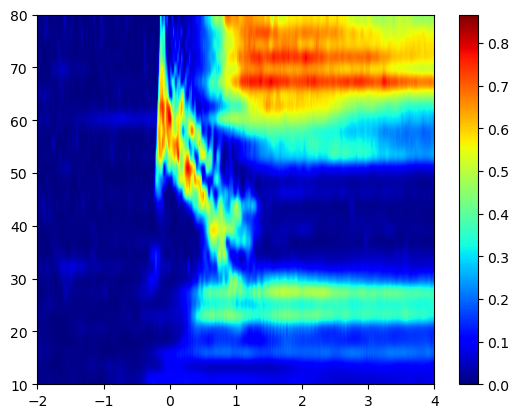

In [52]:
plt.imshow(
    MI_123 - np.minimum(MI_12, MI_13),
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 10, 80],
    cmap="jet",
    vmin=0,
    interpolation="gaussian"
)
plt.colorbar()

In [36]:
z1 = data[:, 0] * np.conj(data[:, 1])

A1 = np.abs(z1).values
dphi1 = np.unwrap(np.angle(z1))

z2 = data[:, 0] * np.conj(data[:, -1])

A2 = np.abs(z2).values
dphi2 = np.unwrap(np.angle(z2))


mv = np.stack((A1, A2), axis=0)
plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))


mv = np.stack((A1, dphi2), axis=0)
plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))

mv = np.stack((dphi1, dphi2), axis=0)
plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))


mv = np.stack((A1, A2, dphi1, dphi2), axis=0)
plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 5999: axis 2 of argument x of type float64[2,100,5999];
  * one axis had size 30: axis 2 of argument y of type float64[1,100,30,3000]

In [ ]:
mv = np.stack((dphi1, dphi2), axis=0)
I12 = mi_fcn_time(mv, labels[None], False, True)

I1 = mi_fcn_time(dphi1[None], labels[None], False, True)

I2 = mi_fcn_time(dphi2[None], labels[None], False, True)

In [ ]:
plt.plot(I12)
plt.plot(I1)
plt.plot(I2)

In [ ]:
PPE = []
as_ = []

for i in tqdm(range(28)):
    for j in range(i + 1, 29):
        z1 = data[:, 0] * np.conj(data[:, i])

        A1 = np.abs(z1).values
        dphi1 = np.unwrap(np.angle(z1))

        I_A = mi_fcn_time(A1[None], labels[None], False, True)
        I_O = mi_fcn_time(dphi1[None], labels[None], False, True)

        dx = data.times.values[1] - data.times.values[0]
        PPE += [np.trapz(I_O - I_A, dx=dx)]
        as_ += [a_model.values[i] - a_model.values[j]]

In [ ]:
from scipy.optimize import curve_fit


def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y


xdata = as_
ydata = PPE

p0 = [max(ydata), np.median(xdata), 1, min(ydata)]  # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)

In [ ]:
p0[0] = 0.7

In [ ]:
plt.scatter(as_, PPE)
plt.plot(np.linspace(-12, 12, 50), sigmoid(np.linspace(-12, 12, 50), *p0), "r")

In [ ]:
dphi = []

z = data[:, 0] * np.conj(data[:, -1])
dphi += [np.stack((data[:, 0].real, data[:, 0].imag))]

z = data[:, 0] * np.conj(data[:, -1])
dphi = np.stack((data[:, 0].imag, data[:, -1].imag))

In [ ]:
mv = np.stack(dphi, axis=0)
plt.plot(
    mi_fcn_time(mv, labels[None], False, True)
    - np.min([mi_fcn_time(e[None], labels[None], False, True) for e in dphi])
)
plt.plot(
    mi_fcn_time(mv, labels[None], False, True)
    - np.max([mi_fcn_time(e[None], labels[None], False, True) for e in dphi])
)

In [ ]:
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import xarray as xr
from frites.conn import conn_io
from frites.io import check_attrs, logger, set_log_level
from frites.utils import parallel_func
from hoi.core import get_mi
from jax.scipy.special import ndtri
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))


def _phase_amplitude(w, foi_idx, x_s, x_t, stim):
    """Compute the MI for each pair"""
    # w = jnp.asarray(w)

    @partial(jax.vmap, in_axes=(0, 0))
    def _pairwise(w_x, w_y):

        edge = w[:, w_x, :, :] * jnp.conj(w[:, w_y, :, :])
        edge_r, edge_i = np.real(edge), np.imag(edge)

        E1 = jnp.stack((edge_r, edge_i), axis=1)
        E1 = jnp.moveaxis(E1, [0, 1], [-1, -2])
        E1 = copnorm_nd(E1, axis=-1)

        return gcmi(E1, stim)

    return _pairwise(x_s, x_t)


def edge_spectral_PID(
    data,
    y,
    freqs=None,
    roi=None,
    times=None,
    sfreq=None,
    foi=None,
    n_cycles=7,
    decim=1,
    mode="phase_amplitude",
    block_size=None,
    n_jobs=-1,
    verbose=None,
    dtype=np.float32,
    **kw_links,
):

    assert mode in ["phase", "amplitude", "phase_amplitude"]

    # _________________________________ INPUTS ________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})

    data, cfg = conn_io(
        data,
        times=times,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        block_size=block_size,
        sfreq=sfreq,
        freqs=freqs,
        foi=foi,
        verbose=verbose,
        name=f"Spectral MI",
        kw_links=kw_links,
    )

    # extract variables
    x, trials, attrs = data.data, data["y"].data, cfg["attrs"]
    times, n_trials = data["times"].data, len(trials)
    x_s, x_t, roi_p = cfg["x_s"], cfg["x_t"], cfg["roi_p"]
    sfreq = cfg["sfreq"]
    freqs, _, foi_idx = cfg["freqs"], cfg["need_foi"], cfg["foi_idx"]
    f_vec = cfg["f_vec"]
    n_pairs, n_freqs = len(x_s), len(freqs)

    x_s = x_s[:, None]
    x_t = x_t[:, None]

    # temporal decimation
    times = times[::decim]

    # define arguments for parallel computing
    mesg = f"Estimating edge spectral PID for trials %s"
    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    # show info
    logger.info(
        f"Estimating edge spectral PID (n_pairs={n_pairs}, "
        f"n_freqs={n_freqs}, decim={decim})"
    )

    # Compute for blocks of channel pairs
    indices = np.arange(n_pairs)
    if isinstance(block_size, int):
        indices = np.array_split(indices, block_size)
    # reshape stimuli
    y = np.expand_dims(y, axis=(0, 1))
    y = np.tile(y, (len(freqs), len(times), 1, 1))
    y = jnp.asarray(copnorm_nd(y, axis=-1))

    conn = np.zeros((n_pairs, len(f_vec), len(times)), dtype=dtype)
    dims = ("roi", "freqs", "times")
    coords = (roi_p, f_vec, times)

    # --------------------------- TIME-FREQUENCY --------------------------
    # time-frequency decomposition
    w = tfr_array_morlet(
        x,
        sfreq,
        freqs,
        n_cycles=n_cycles,
        decim=decim,
        n_jobs=n_jobs,
        output="complex",
    )

    w = jnp.asarray(w)